In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import caffe

import lib.imageutl as imutl
import lib.visualizationutl as view
import lib.dataaug as aug

%matplotlib inline

In [25]:
pathdataset = '../db'
namedataset = 'car'
metadata = 'metadata.csv'
runlencodesample = 'sample_submission.csv'
runlencode = 'runlen.csv'

pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)
pathrunlencodesample = os.path.join(pathdataset, namedataset, runlencodesample)

print(pathname)
print(pathmetadata)
print(pathrunlencodesample)


../db/car
../db/car/metadata.csv
../db/car/sample_submission.csv


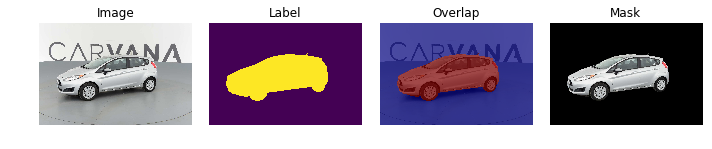

(1280, 1918, 3)


In [26]:
data = imutl.dataProvide( pathname, fn_image='train', fn_label='train_masks', lext='gif')
view.display_image_and_gt( data )
print(data.getimage(0).shape)

In [8]:
mdatarl = pd.read_csv(pathrunlencodesample)
mdatarl.head()

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1


In [4]:

# Run-Length Encode and Decode
import time

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Time Test
masks = pd.read_csv('../db/car/train_masks.csv')
num_masks = masks.shape[0]
print('Total masks to encode/decode =', num_masks)

time_enc = 0.0 # seconds
time_dec = 0.0 # seconds

for r in masks.itertuples():
    t0 = time.clock()
    mask = rle_decode(r.rle_mask,(1280,1918))
    time_dec += time.clock() - t0
    t0 = time.clock()   
    mask_rle = rle_encode(mask)
    time_enc += time.clock() - t0
    assert (mask_rle == r.rle_mask)

print('Time full encoding = {:.4f} ms per mask'.format(1000*time_enc/num_masks))
print('Time full decoding = {:.4f} ms per mask'.format(1000*time_dec/num_masks))

test_mask = np.asarray([[0, 0, 0, 0], [0, 0, 1, 1], [0, 0, 1, 1], [0, 0, 0, 0]])
assert rle_encode(test_mask) == '7 2 11 2'
print(test_mask)
print(rle_encode(test_mask))


image = data.getimage(0);
label = data.getlabel()

rl = rle_encode(label);
label_hat = rle_decode(rl, label.shape)
label_err = np.abs(label_hat&(1-label));

plt.subplot(131);
plt.imshow(label)
plt.subplot(132);
plt.imshow(label_hat)
plt.subplot(133);
plt.imshow(label_err)
plt.show()

print(np.sum(label_err) )




('Total masks to encode/decode =', 5088)
Time full encoding = 5.7266 ms per mask
Time full decoding = 1.9043 ms per mask
[[0 0 0 0]
 [0 0 1 1]
 [0 0 1 1]
 [0 0 0 0]]
7 2 11 2


NameError: name 'data' is not defined

In [22]:

datarow = [{'img':'xxx.jpg', 'rle_mask':'7 2 11 2'}, {'img':'xxx.jpg', 'rle_mask':'7 2 11 2'}]
df = pd.DataFrame(datarow)
filename = 'test.csv'
df.to_csv(filename, index=False, encoding='utf-8')
rl = pd.read_csv(filename)
rl.head()



,img,rle_mask
0,xxx.jpg,7 2 11 2
1,xxx.jpg,7 2 11 2


                   img                                           rle_mask
0  00087a6bd4dc_01.jpg  873660 1 873666 4 875519 1 875558 7 875577 3 8...
1  00087a6bd4dc_02.jpg  873660 1 873776 2 873779 8 875562 1 875564 1 8...
2  00087a6bd4dc_03.jpg  875800 2 875804 1 877711 1 877716 3 877721 2 8...
3  00087a6bd4dc_04.jpg  877822 5 879735 15 881649 22 883291 1 883293 1...
4  00087a6bd4dc_05.jpg  881720 14 883432 2 883633 16 883650 10 885263 ...
5


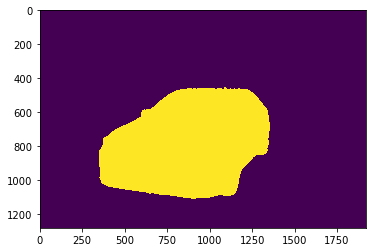

In [12]:

#filename = '../db/car/train_masks.csv'
#filename = '../out/test_masks.csv'
filename = '../pytorch-semseg-master/test_masks.csv'
rl = pd.read_csv(filename)
print(rl.head())
print(rl.shape[0])

imagname = rl['img'];
rle_mask = rl['rle_mask']

label = rle_decode(rle_mask[1],(1280,1918))
plt.imshow(label)
plt.show()
